In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import plotly.graph_objects as go
from plotly.graph_objs.scatter.marker import Line
from plotly.subplots import make_subplots
import plotly.express as px

Data Ingestion

In [4]:
data = pd.read_excel('2years_database.xlsx', sheet_name='DATA')

data['Sp-close'] = data['Sp-close'].str.replace(',', '')
data['Volume'] = data['Volume'].str.replace(',', '')
data['Sp-close'] = pd.to_numeric(data['Sp-close'])
data['Volume'] = pd.to_numeric(data['Volume'])
data['Vix-close'] = pd.to_numeric(data['Vix-close'])
data

,Date,Sp-close,Volume,Vix-close
0,2021-03-01,3901.82,5114820000,23.35
1,2021-03-02,3870.29,5536010000,24.10
2,2021-03-03,3819.72,6173660000,26.67
3,2021-03-04,3768.47,7195400000,28.57
4,2021-03-05,3841.94,6851070000,24.66
...,...,...,...,...
494,2023-02-15,4147.60,4075980000,18.23
495,2023-02-16,4090.41,4143660000,20.17
496,2023-02-17,4079.09,4045480000,20.02
497,2023-02-21,3997.34,4121590000,22.87


VIX & S&P time series

In [5]:
trading_instrument = 'Sp-close'
fig = px.line(data, x='Date', y='Sp-close', title=f'{trading_instrument} Time Series')
fig.show()

In [6]:
trading_instrument = 'Vix-close'
fig = px.line(data, x='Date', y='Vix-close', title=f'{trading_instrument} Time Series')
fig.show()

Identifying optimal number of clusters

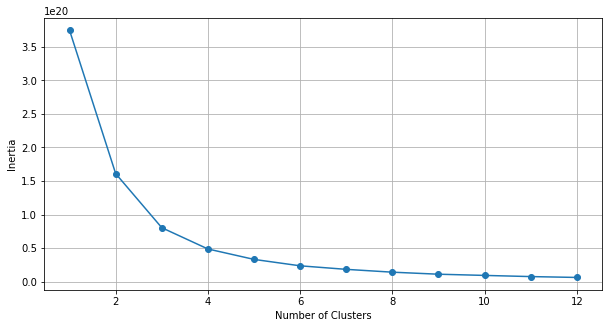

In [7]:
def optimise_k_means(dt, max_k):
    means=[] #the number of clusters used for each model
    inertias=[] #sum of squared distances of samples to their closest cluster center for each model
    for k in range(1, max_k):
        kmeans =  KMeans(n_clusters=k)
        kmeans.fit(dt)
        means.append(k)
        inertias.append(kmeans.inertia_)
        
    #generate the elbow plot
    fig = plt.subplots(figsize=(10,5))
    plt.plot(means,inertias,'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()
optimise_k_means(data[["Sp-close", "Volume", "Vix-close"]],13)

Data Engineering 

In [8]:
scaler = MinMaxScaler()    #x' = (x - min) / (max - min) Normalization
normalized_columns = ["Norm_Sp_Close", "Norm_Volume", "Norm_Vix_close"]
data[normalized_columns] = scaler.fit_transform(data[["Sp-close", "Volume", "Vix-close"]])

# Perform k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['kmeans_3'] = kmeans.fit_predict(data[normalized_columns])

In [10]:
# Calculate the centroids
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_),
                         columns=['Sp-close', 'Volume', 'Vix-close'])

print(centroids)

      Sp-close        Volume  Vix-close
0  4516.258258  4.125253e+09  19.294494
1  3971.119500  5.028840e+09  28.811357
2  4070.301381  4.245591e+09  20.353702


In [12]:
data['returns'] = data['Sp-close'].pct_change()
data.dropna(inplace=True)

Clusters scatterplot

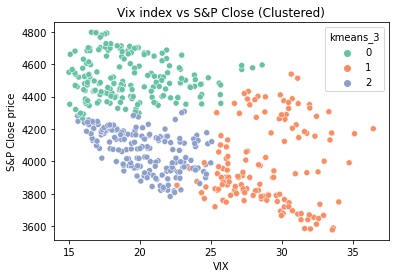

In [13]:
sns.scatterplot(x=data['Vix-close'], y=data['Sp-close'], hue=data['kmeans_3'], palette='Set2')
plt.xlabel('VIX')
plt.ylabel('S&P Close price')
plt.title('Vix index vs S&P Close (Clustered)')
plt.show()

By changing the period

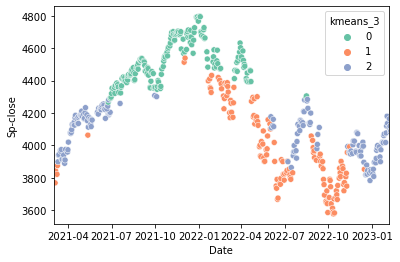

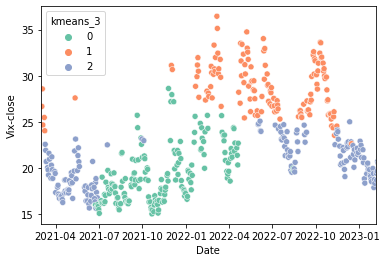

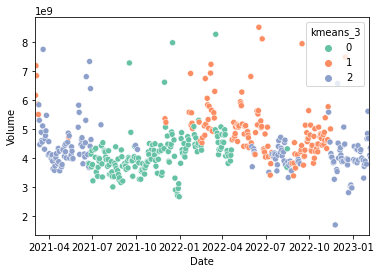

In [14]:
#S&P close
sns.scatterplot(x=data['Date'], y=data['Sp-close'], hue=data['kmeans_3'], palette='Set2')
plt.xlim([pd.Timestamp('2021-03-01'), pd.Timestamp('2023-02-05')])
plt.show()

#VIX Index
sns.scatterplot(x=data['Date'], y=data['Vix-close'], hue=data['kmeans_3'], palette='Set2')
plt.xlim([pd.Timestamp('2021-03-01'), pd.Timestamp('2023-02-05')])
plt.show()

#s&p volume
sns.scatterplot(x=data['Date'], y=data['Volume'], hue=data['kmeans_3'], palette='Set2')
plt.xlim([pd.Timestamp('2021-03-01'), pd.Timestamp('2023-02-05')])
plt.show()

If you want save data with clusters in excel file - 
data.to_excel("data_with_clusters.xlsx", index=False)

In [15]:
#Calculate the mean values of each feature within each cluster
centroids = data.groupby('kmeans_3').mean()
print(centroids)

             Sp-close        Volume  Vix-close  Norm_Sp_Close  Norm_Volume  \
kmeans_3                                                                     
0         4516.258258  4.125253e+09  19.294494       0.770156     0.354959   
1         3971.844892  5.025191e+09  28.845252       0.323743     0.487026   
2         4071.237389  4.240762e+09  20.337056       0.405244     0.371911   

          Norm_Vix_close   returns  
kmeans_3                            
0               0.199836  0.000937  
1               0.645301 -0.002527  
2               0.248463  0.001404  


In [16]:
cluster_stats = data.groupby('kmeans_3')['returns'].agg(['mean', 'count'])
cluster_stats['positive_returns'] = (data[data['returns'] > 0]
                                     .groupby('kmeans_3')['returns'].count())
cluster_stats['negative_returns'] = (data[data['returns'] < 0]
                                     .groupby('kmeans_3')['returns'].count())
cluster_stats['label'] = ['Bullish' if mean_return > 0 else 'Bearish'
                          for mean_return in cluster_stats['mean']]


In [17]:
print(cluster_stats)

              mean  count  positive_returns  negative_returns    label
kmeans_3                                                              
0         0.000937    178               104                74  Bullish
1        -0.002527    139                51                88  Bearish
2         0.001404    180                91                89  Bullish


In [19]:
market_regime_map = {
  0: 'Low-volatility / Bullish market',
  1: 'High-volatility / Bearish market',
  2: 'Low-volatility / Stable market',

}

data['Market Regime'] = data['kmeans_3'].map(market_regime_map)
data.head(4)

,Date,Sp-close,Volume,Vix-close,Norm_Sp_Close,Norm_Volume,Norm_Vix_close,kmeans_3,returns,Market Regime
2,2021-03-03,3819.72,6173660000,26.67,0.199003,0.655564,0.543843,1,-0.013066,High-volatility / Bearish market
3,2021-03-04,3768.47,7195400000,28.57,0.156979,0.805505,0.632463,1,-0.013417,High-volatility / Bearish market
4,2021-03-05,3841.94,6851070000,24.66,0.217223,0.754975,0.450093,1,0.019496,High-volatility / Bearish market
5,2021-03-08,3821.35,5871710000,25.47,0.200339,0.611253,0.487873,1,-0.005359,High-volatility / Bearish market


Ploting results

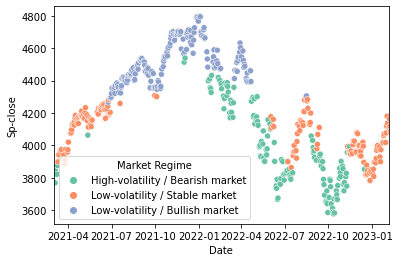

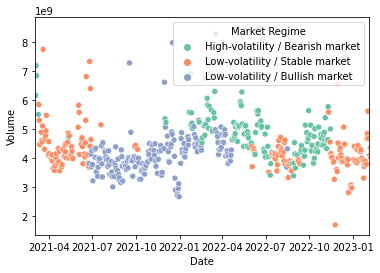

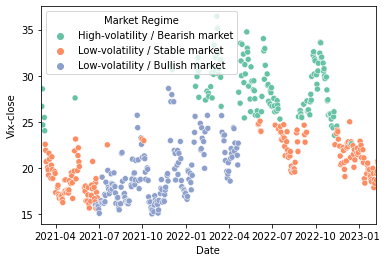

In [24]:
sns.scatterplot(x=data['Date'], y=data['Sp-close'], hue=data['Market Regime'], palette='Set2')
plt.xlim([pd.Timestamp('2021-03-01'), pd.Timestamp('2023-02-05')])
plt.show()

sns.scatterplot(x=data['Date'], y=data['Volume'], hue=data['Market Regime'], palette='Set2')
plt.xlim([pd.Timestamp('2021-03-01'), pd.Timestamp('2023-02-05')])
plt.show()

sns.scatterplot(x=data['Date'], y=data['Vix-close'], hue=data['Market Regime'], palette='Set2')
plt.xlim([pd.Timestamp('2021-03-01'), pd.Timestamp('2023-02-05')])
plt.show()

Boxplots

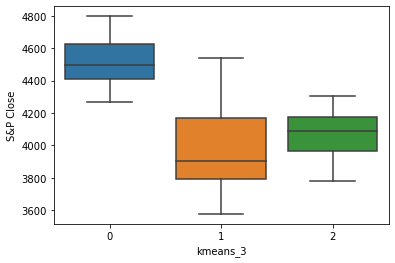

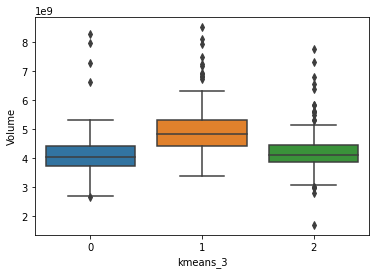

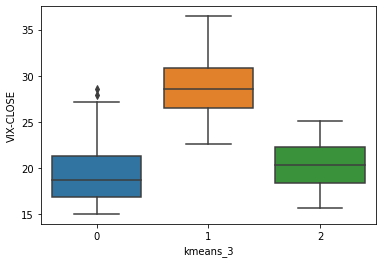

In [23]:
sns.boxplot(x='kmeans_3', y='Sp-close', data=data)
plt.ylabel('S&P Close')
plt.show()

sns.boxplot(x='kmeans_3', y='Volume', data=data)
plt.ylabel('Volume')
plt.show()

sns.boxplot(x='kmeans_3', y='Vix-close', data=data)
plt.ylabel('VIX-CLOSE')
plt.show()